This notebook contains code related to an investigation on mmseqs2's Neff scores.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from af22c import neff
from af22c.mmseqs import mmseqs_neff_from_a3m
from af22c.msa import EncMsa
from af22c.scores import pwseq, identity_seq_weights, henikoff_seq_weights
import matplotlib.pyplot as plt

In [4]:
mmseqs = "/home/johannes/uni/idp/MMseqs2/cmake-build-debug/src/mmseqs"
MSA_PATH = "../data/Q9AAS4.a3m"
MSA_PATH = "/home/johannes/uni/idp/MMseqs2/test/mini.a3m"

In [32]:
mmseqs_scores = {
  k: mmseqs_neff_from_a3m(
    MSA_PATH, mmseqs, {"msa2profile": k}
  )
  for k in ["--wg 0", "--wg 1"]
}

In [24]:
msa = EncMsa.from_thing(MSA_PATH)

In [25]:
M = F.one_hot(msa.data.long(), len(msa.vocab))

In [26]:
# NB: this is not Heinkoff weighting, but seqid weighting!
w = henikoff_seq_weights(msa, verbose=1); w

calc weights: 100%|██████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2462.17it/s]


tensor([0.2812, 0.2188, 0.2396, 0.2604])

In [27]:
f = torch.einsum("i,ijk->jk", w, M.float())

In [28]:
nf = f / f.sum(dim=1).view(-1,1) + 1e-4 # TODO: find out whether +1 is ok

In [29]:
nf.shape

torch.Size([8, 22])

In [30]:
neff = 2 ** (-(nf * nf.log2()).sum(1) / msa.data.shape[1])

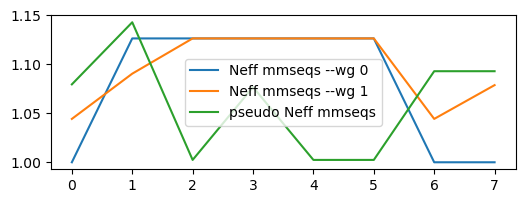

In [33]:
plt.figure(figsize=(6,2))
for k, v in mmseqs_scores.items():
  plt.plot(v,label="Neff mmseqs " + k)
plt.plot(neff,label="pseudo Neff mmseqs")
plt.legend();